This notebook is essentially just a quick and dirty run through the data science pipeline to get an MVP. I will refine my process in other notebooks. This model is pretty near useless as it only looks at the stats of the first fighter. See prepare notebook for process of planning and preparing the data. 

# UFC Fight Card Predictor

## About this Project:

### Project Goal: 

The goal of this project is to be able to read in an upcoming fight card and predict the outcome of each fight. 


For this particular project we will be looking at UFC 272 PPV - Colby Covington vs. Jorge Masvidal.

### Project Description: 

## Let's Get Started... 

### Imports

These are the following imports needed to run this notebook: 

In [93]:
import numpy as np
import pandas as pd

# Visualizing
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:.2f}'.format

# Split 
from sklearn.model_selection import train_test_split

# Scale
from sklearn.preprocessing import MinMaxScaler

# Stats
import scipy.stats as stats

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Classification Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Acquire

The first thing we have to do is acquire the data. I will be using a dataset called ufc-master.csv that I found here: 

https://www.kaggle.com/bloodprashure/ufc-p4p-1-dataset/tasks?taskId=4669

Before reading this csv I cleaned the column names to make them easier to work with in python. 

In [2]:
# read csv locally 
ufc = pd.read_csv('ufc-master-cleaned.csv')

In [3]:
# verify data was properly acquired
ufc.head(1)

,Unnamed: 0,date,event_code,event_name,fullname,fighter_two_name,w,l,d,nc,...,round_five_takedown_percent,round_five_submission_attempt,round_five_submission_reverse,round_five_control_time,round_five_head,round_five_body,round_five_leg,round_five_distance,round_five_clinch,round_five_ground
0,0,2021-03-06 0:00:00,6e2b1d631832921d,UFC 259: Blachowicz vs. Adesanya,Aalon Cruz,Uros Medic,0,1,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# check row/column shape
ufc.shape

(12156, 171)

### The Plan

This df has 172 columns. 

A lot of these columns are full of stats from that specific event, so since I will not have these stats prior to the fight, I won't want to use them as features. 

I will now create a df of stats that I can know before the fight that already exist like height/weight etc.. 

I'll clean and prepare the data. 

After that I can do some exploring and create an mvp,… 

I'll go back to the original df and do more exploration with the goal of creating new features from the stats from past fights that i can turn into averages for that fighter. 

I’ll redo the models with the new features. 

### Prepare

In [5]:
# add the columns I would like to work with into a new df
ufc_cleaned = ufc[['event_name', 'fullname', 'fighter_two_name', 'w', 'l', 'd', 'nc', 'total_rounds', 'belt', 'womens_bout', 'interim_bout', 'strawweight', 'flyweight', 'bantamweight', 'featherweight', 'lightweight', 'middleweight', 'light_heavyweight', 'heavyweight', 'catch_weight', 'open_weight', 'super_heavyweight', 'superfight', 'fight_city', 'fight_state', 'fight_country', 'height', 'weight', 'reach', 'stance', 'slpm', 'stracc', 'sapm', 'strdef', 'tdavg', 'tdacc', 'tddef', 'subavg', 'age_days', 'age']].copy(0)

In [6]:
ufc_cleaned.head()

,event_name,fullname,fighter_two_name,w,l,d,nc,total_rounds,belt,womens_bout,...,slpm,stracc,sapm,strdef,tdavg,tdacc,tddef,subavg,age_days,age
0,UFC 259: Blachowicz vs. Adesanya,Aalon Cruz,Uros Medic,0,1,0,0,3,0,0,...,7.58,39,8.88,58,0.00,0,0,0.00,11490,31.00
1,UFC Fight Night: Benavidez vs. Figueiredo,Aalon Cruz,Spike Carlyle,0,1,0,0,3,0,0,...,7.58,39,8.88,58,0.00,0,0,0.00,11119,30.00
2,UFC 28: High Stakes,Aaron Brink,Andrei Arlovski,0,1,0,0,3,0,0,...,3.49,42,5.71,57,0.00,0,0,0.00,9502,26.00
3,UFC Fight Night: Henderson vs Dos Anjos,Aaron Phillips,Matt Hobar,0,1,0,0,3,0,0,...,1.65,56,3.44,39,0.00,0,44,0.40,9149,25.00
4,UFC Fight Night: Kattar vs. Ige,Aaron Phillips,Jack Shore,0,1,0,0,3,0,0,...,1.65,56,3.44,39,0.00,0,44,0.40,11302,30.00


In [7]:
ufc_cleaned.shape

(12156, 40)

In [8]:
# Drop duplicates if any

print(ufc_cleaned.shape)
df = ufc_cleaned.drop_duplicates()
print(ufc_cleaned.shape)

(12156, 40)
(12156, 40)


There are no duplicates.

In [9]:
# combine w, l, d, nc into on target column called outcome

In [10]:
cols = ['w', 'l', 'd', 'nc']
ufc_cleaned['outcome'] = ufc_cleaned[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [11]:
ufc_cleaned.sample(1)

,event_name,fullname,fighter_two_name,w,l,d,nc,total_rounds,belt,womens_bout,...,stracc,sapm,strdef,tdavg,tdacc,tddef,subavg,age_days,age,outcome
7377,UFC Fight Night: Smith vs. Rakic,Mallory Martin,Hannah Cifers,1,0,0,0,3,0,1,...,59,5.53,58,3.37,63,25,0.50,9709,26.00,1_0_0_0


In [12]:
# rename the labels in outcome to be human readable 

In [13]:
ufc_cleaned['outcome'].replace({'1_0_0_0': 'win', '0_1_0_0': 'loss', '0_0_1_0': 'draw', '0_0_0_1': 'no_contest'}, inplace=True)

In [14]:
ufc_cleaned.head()

,event_name,fullname,fighter_two_name,w,l,d,nc,total_rounds,belt,womens_bout,...,stracc,sapm,strdef,tdavg,tdacc,tddef,subavg,age_days,age,outcome
0,UFC 259: Blachowicz vs. Adesanya,Aalon Cruz,Uros Medic,0,1,0,0,3,0,0,...,39,8.88,58,0.00,0,0,0.00,11490,31.00,loss
1,UFC Fight Night: Benavidez vs. Figueiredo,Aalon Cruz,Spike Carlyle,0,1,0,0,3,0,0,...,39,8.88,58,0.00,0,0,0.00,11119,30.00,loss
2,UFC 28: High Stakes,Aaron Brink,Andrei Arlovski,0,1,0,0,3,0,0,...,42,5.71,57,0.00,0,0,0.00,9502,26.00,loss
3,UFC Fight Night: Henderson vs Dos Anjos,Aaron Phillips,Matt Hobar,0,1,0,0,3,0,0,...,56,3.44,39,0.00,0,44,0.40,9149,25.00,loss
4,UFC Fight Night: Kattar vs. Ige,Aaron Phillips,Jack Shore,0,1,0,0,3,0,0,...,56,3.44,39,0.00,0,44,0.40,11302,30.00,loss


In [15]:
# rename fullname and fighter_two_name to fighter and opponent respectively

In [16]:
ufc_cleaned.rename(columns={'fullname': 'fighter', 'fighter_two_name': 'opponent'}, inplace=True)

In [17]:
ufc_cleaned.head()

,event_name,fighter,opponent,w,l,d,nc,total_rounds,belt,womens_bout,...,stracc,sapm,strdef,tdavg,tdacc,tddef,subavg,age_days,age,outcome
0,UFC 259: Blachowicz vs. Adesanya,Aalon Cruz,Uros Medic,0,1,0,0,3,0,0,...,39,8.88,58,0.00,0,0,0.00,11490,31.00,loss
1,UFC Fight Night: Benavidez vs. Figueiredo,Aalon Cruz,Spike Carlyle,0,1,0,0,3,0,0,...,39,8.88,58,0.00,0,0,0.00,11119,30.00,loss
2,UFC 28: High Stakes,Aaron Brink,Andrei Arlovski,0,1,0,0,3,0,0,...,42,5.71,57,0.00,0,0,0.00,9502,26.00,loss
3,UFC Fight Night: Henderson vs Dos Anjos,Aaron Phillips,Matt Hobar,0,1,0,0,3,0,0,...,56,3.44,39,0.00,0,44,0.40,9149,25.00,loss
4,UFC Fight Night: Kattar vs. Ige,Aaron Phillips,Jack Shore,0,1,0,0,3,0,0,...,56,3.44,39,0.00,0,44,0.40,11302,30.00,loss


In [18]:
ufc_cleaned.dtypes

event_name            object
fighter               object
opponent              object
w                      int64
l                      int64
d                      int64
nc                     int64
total_rounds           int64
belt                   int64
womens_bout            int64
interim_bout           int64
strawweight            int64
flyweight              int64
bantamweight           int64
featherweight          int64
lightweight            int64
middleweight           int64
light_heavyweight      int64
heavyweight            int64
catch_weight           int64
open_weight            int64
super_heavyweight      int64
superfight             int64
fight_city            object
fight_state           object
fight_country         object
height                object
weight               float64
reach                float64
stance                object
slpm                 float64
stracc                 int64
sapm                 float64
strdef                 int64
tdavg         

I want to convert height to a float value. I will also convert it to inches to make it more workable. 

In [19]:
# check the min and max vals for height

In [20]:
ufc_cleaned.height.min()

'--'

In [21]:
ufc_cleaned.height.max()

'6\' 8"'

In [22]:
# replace the -- with 0' 0" so my function below will work

In [23]:
ufc_cleaned['height'].replace({'--': "0' 0\""}, inplace=True)

In [24]:
ufc_cleaned.height.min()

'0\' 0"'

In [25]:
# convert ft to in

In [26]:
def parse_ht(ht):
    # format: 7' 0.0"
    ht_ = ht.split("' ")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_



In [27]:
# apply parse_ht

In [28]:
ufc_cleaned["height_in"] = ufc_cleaned["height"].apply(lambda x:parse_ht(x))

In [29]:
ufc_cleaned.head(1)

,event_name,fighter,opponent,w,l,d,nc,total_rounds,belt,womens_bout,...,sapm,strdef,tdavg,tdacc,tddef,subavg,age_days,age,outcome,height_in
0,UFC 259: Blachowicz vs. Adesanya,Aalon Cruz,Uros Medic,0,1,0,0,3,0,0,...,8.88,58,0.00,0,0,0.00,11490,31.00,loss,72.00


In [30]:
# convert float to int

In [31]:
ufc_cleaned['height_in'] = ufc_cleaned.height_in.astype(int) 

In [32]:
ufc_cleaned.height_in.head()

0    72
1    72
2    75
3    69
4    69
Name: height_in, dtype: int64

In [33]:
# check for nulls

In [34]:
ufc_cleaned.isnull().sum()

event_name              0
fighter                 0
opponent                0
w                       0
l                       0
d                       0
nc                      0
total_rounds            0
belt                    0
womens_bout             0
interim_bout            0
strawweight             0
flyweight               0
bantamweight            0
featherweight           0
lightweight             0
middleweight            0
light_heavyweight       0
heavyweight             0
catch_weight            0
open_weight             0
super_heavyweight       0
superfight              0
fight_city              0
fight_state          1012
fight_country           1
height                  0
weight                 13
reach                1292
stance                 95
slpm                    0
stracc                  0
sapm                    0
strdef                  0
tdavg                   0
tdacc                   0
tddef                   0
subavg                  0
age_days    

In [35]:
# fill fight_state null values with the mode which is Navada

In [36]:
ufc_cleaned['fight_state'] = ufc_cleaned.fight_state.fillna(ufc_cleaned.fight_state.mode()[0])

In [37]:
ufc_cleaned.isnull().sum()

event_name              0
fighter                 0
opponent                0
w                       0
l                       0
d                       0
nc                      0
total_rounds            0
belt                    0
womens_bout             0
interim_bout            0
strawweight             0
flyweight               0
bantamweight            0
featherweight           0
lightweight             0
middleweight            0
light_heavyweight       0
heavyweight             0
catch_weight            0
open_weight             0
super_heavyweight       0
superfight              0
fight_city              0
fight_state             0
fight_country           1
height                  0
weight                 13
reach                1292
stance                 95
slpm                    0
stracc                  0
sapm                    0
strdef                  0
tdavg                   0
tdacc                   0
tddef                   0
subavg                  0
age_days    

In [38]:
# drop null rows in weight column

In [39]:
ufc_cleaned = ufc_cleaned[ufc_cleaned.weight.notnull()]

In [40]:
ufc_cleaned.isnull().sum()

event_name              0
fighter                 0
opponent                0
w                       0
l                       0
d                       0
nc                      0
total_rounds            0
belt                    0
womens_bout             0
interim_bout            0
strawweight             0
flyweight               0
bantamweight            0
featherweight           0
lightweight             0
middleweight            0
light_heavyweight       0
heavyweight             0
catch_weight            0
open_weight             0
super_heavyweight       0
superfight              0
fight_city              0
fight_state             0
fight_country           1
height                  0
weight                  0
reach                1279
stance                 84
slpm                    0
stracc                  0
sapm                    0
strdef                  0
tdavg                   0
tdacc                   0
tddef                   0
subavg                  0
age_days    

In [41]:
# drop null rows in reach column

In [42]:
ufc_cleaned = ufc_cleaned[ufc_cleaned.reach.notnull()]

In [43]:
ufc_cleaned.isnull().sum()

event_name            0
fighter               0
opponent              0
w                     0
l                     0
d                     0
nc                    0
total_rounds          0
belt                  0
womens_bout           0
interim_bout          0
strawweight           0
flyweight             0
bantamweight          0
featherweight         0
lightweight           0
middleweight          0
light_heavyweight     0
heavyweight           0
catch_weight          0
open_weight           0
super_heavyweight     0
superfight            0
fight_city            0
fight_state           0
fight_country         1
height                0
weight                0
reach                 0
stance               12
slpm                  0
stracc                0
sapm                  0
strdef                0
tdavg                 0
tdacc                 0
tddef                 0
subavg                0
age_days              0
age                  11
outcome               0
height_in       

In [44]:
# drop null rows in stance column

In [45]:
ufc_cleaned = ufc_cleaned[ufc_cleaned.stance.notnull()]

In [46]:
# drop null rows in age column

In [47]:
ufc_cleaned = ufc_cleaned[ufc_cleaned.age.notnull()]

In [48]:
ufc_cleaned.isnull().sum()

event_name           0
fighter              0
opponent             0
w                    0
l                    0
d                    0
nc                   0
total_rounds         0
belt                 0
womens_bout          0
interim_bout         0
strawweight          0
flyweight            0
bantamweight         0
featherweight        0
lightweight          0
middleweight         0
light_heavyweight    0
heavyweight          0
catch_weight         0
open_weight          0
super_heavyweight    0
superfight           0
fight_city           0
fight_state          0
fight_country        1
height               0
weight               0
reach                0
stance               0
slpm                 0
stracc               0
sapm                 0
strdef               0
tdavg                0
tdacc                0
tddef                0
subavg               0
age_days             0
age                  0
outcome              0
height_in            0
dtype: int64

In [49]:
# drop null rows in fight_country column

In [50]:
ufc_cleaned = ufc_cleaned[ufc_cleaned.fight_country.notnull()]

In [51]:
ufc_cleaned.isnull().sum()

event_name           0
fighter              0
opponent             0
w                    0
l                    0
d                    0
nc                   0
total_rounds         0
belt                 0
womens_bout          0
interim_bout         0
strawweight          0
flyweight            0
bantamweight         0
featherweight        0
lightweight          0
middleweight         0
light_heavyweight    0
heavyweight          0
catch_weight         0
open_weight          0
super_heavyweight    0
superfight           0
fight_city           0
fight_state          0
fight_country        0
height               0
weight               0
reach                0
stance               0
slpm                 0
stracc               0
sapm                 0
strdef               0
tdavg                0
tdacc                0
tddef                0
subavg               0
age_days             0
age                  0
outcome              0
height_in            0
dtype: int64

In [52]:
# drop nulls to make sure none were missed
df = df.dropna()

In [53]:
ufc_cleaned.isnull().sum()

event_name           0
fighter              0
opponent             0
w                    0
l                    0
d                    0
nc                   0
total_rounds         0
belt                 0
womens_bout          0
interim_bout         0
strawweight          0
flyweight            0
bantamweight         0
featherweight        0
lightweight          0
middleweight         0
light_heavyweight    0
heavyweight          0
catch_weight         0
open_weight          0
super_heavyweight    0
superfight           0
fight_city           0
fight_state          0
fight_country        0
height               0
weight               0
reach                0
stance               0
slpm                 0
stracc               0
sapm                 0
strdef               0
tdavg                0
tdacc                0
tddef                0
subavg               0
age_days             0
age                  0
outcome              0
height_in            0
dtype: int64

No more null values.

In [54]:
# create dummy columns for stance column

In [55]:
dummy_df = pd.get_dummies(ufc_cleaned[['stance']], dummy_na=False, drop_first=[False])
ufc_cleaned = pd.concat([ufc_cleaned, dummy_df], axis=1)

In [56]:
ufc_cleaned.head(1)

,event_name,fighter,opponent,w,l,d,nc,total_rounds,belt,womens_bout,...,tdacc,tddef,subavg,age_days,age,outcome,height_in,stance_Orthodox,stance_Southpaw,stance_Switch
0,UFC 259: Blachowicz vs. Adesanya,Aalon Cruz,Uros Medic,0,1,0,0,3,0,0,...,0,0,0.00,11490,31.00,loss,72,0,0,1


In [57]:
# double check to make sure datatype are good

In [58]:
ufc_cleaned.dtypes

event_name            object
fighter               object
opponent              object
w                      int64
l                      int64
d                      int64
nc                     int64
total_rounds           int64
belt                   int64
womens_bout            int64
interim_bout           int64
strawweight            int64
flyweight              int64
bantamweight           int64
featherweight          int64
lightweight            int64
middleweight           int64
light_heavyweight      int64
heavyweight            int64
catch_weight           int64
open_weight            int64
super_heavyweight      int64
superfight             int64
fight_city            object
fight_state           object
fight_country         object
height                object
weight               float64
reach                float64
stance                object
slpm                 float64
stracc                 int64
sapm                 float64
strdef                 int64
tdavg         

In [59]:
# Drop height column
cols_to_drop = ['height']
ufc_cleaned = ufc_cleaned.drop(columns=cols_to_drop)

Now that the data is prepped, I'll make a function so that the prep stage won't clutter my final report notebook. 

In [62]:
def get_n_prep_ufc(): 
    
    # imports
    import pandas as pd
    # Ignore Warnings
    import warnings
    warnings.filterwarnings("ignore")
    
    # read .csv
    ufc = pd.read_csv('ufc-master-cleaned.csv')
    
    # add the columns I would like to work with into a new df
    ufc_cleaned = ufc[['event_name', 'fullname', 'fighter_two_name', 'w', 'l', 'd', 'nc', 'total_rounds', 'belt', 'womens_bout', 'interim_bout', 'strawweight', 'flyweight', 'bantamweight', 'featherweight', 'lightweight', 'middleweight', 'light_heavyweight', 'heavyweight', 'catch_weight', 'open_weight', 'super_heavyweight', 'superfight', 'fight_city', 'fight_state', 'fight_country', 'height', 'weight', 'reach', 'stance', 'slpm', 'stracc', 'sapm', 'strdef', 'tdavg', 'tdacc', 'tddef', 'subavg', 'age_days', 'age']].copy(0)
    
    # Drop duplicates if any
    df = ufc_cleaned.drop_duplicates()
    
    # combine w, l, d, nc into on target column called outcome
    cols = ['w', 'l', 'd', 'nc']
    ufc_cleaned['outcome'] = ufc_cleaned[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    
    # rename the labels in outcome to be human readable 
    ufc_cleaned['outcome'].replace({'1_0_0_0': 'win', '0_1_0_0': 'loss', '0_0_1_0': 'draw', '0_0_0_1': 'no_contest'}, inplace=True)
    
    # rename fullname and fighter_two_name to fighter and opponent respectively
    ufc_cleaned.rename(columns={'fullname': 'fighter', 'fighter_two_name': 'opponent'}, inplace=True)
    
    # clean height column
    
    # replace the -- with 0' 0" so my function below will work
    ufc_cleaned['height'].replace({'--': "0' 0\""}, inplace=True)
    
    # convert ft to in
    def parse_ht(ht):
        # format: 7' 0.0"
        ht_ = ht.split("' ")
        ft_ = float(ht_[0])
        in_ = float(ht_[1].replace("\"",""))
        return (12*ft_) + in_
    
    # apply parse_ht
    ufc_cleaned["height_in"] = ufc_cleaned["height"].apply(lambda x:parse_ht(x))

    # convert float to int
    ufc_cleaned['height_in'] = ufc_cleaned.height_in.astype(int) 
    
    # handle null values
    
    # fill fight_state null values with the mode which is Navada
    ufc_cleaned['fight_state'] = ufc_cleaned.fight_state.fillna(ufc_cleaned.fight_state.mode()[0])
    
    # drop null rows in specific columns
    ufc_cleaned = ufc_cleaned[ufc_cleaned.weight.notnull()]
    ufc_cleaned = ufc_cleaned[ufc_cleaned.reach.notnull()]
    ufc_cleaned = ufc_cleaned[ufc_cleaned.stance.notnull()]
    ufc_cleaned = ufc_cleaned[ufc_cleaned.age.notnull()]
    ufc_cleaned = ufc_cleaned[ufc_cleaned.fight_country.notnull()]
    
    # drop nulls to make sure none were missed
    df = df.dropna()
    
    # create dummy columns for stance column and concat to df
    dummy_df = pd.get_dummies(ufc_cleaned[['stance']], dummy_na=False, drop_first=[False])
    ufc_cleaned = pd.concat([ufc_cleaned, dummy_df], axis=1)
    
    # Drop height and index column
    cols_to_drop = ['height']
    ufc_cleaned = ufc_cleaned.drop(columns=cols_to_drop)

    return ufc_cleaned
    
    

In [165]:
# Remove Limits On Viewing Dataframes
pd.set_option('display.max_columns', None)

In [166]:
ufc_cleaned = get_n_prep_ufc()

In [167]:
ufc_cleaned.head()

,event_name,fighter,opponent,w,l,d,nc,total_rounds,belt,womens_bout,interim_bout,strawweight,flyweight,bantamweight,featherweight,lightweight,middleweight,light_heavyweight,heavyweight,catch_weight,open_weight,super_heavyweight,superfight,fight_city,fight_state,fight_country,weight,reach,stance,slpm,stracc,sapm,strdef,tdavg,tdacc,tddef,subavg,age_days,age,outcome,height_in,stance_Orthodox,stance_Southpaw,stance_Switch
0,UFC 259: Blachowicz vs. Adesanya,Aalon Cruz,Uros Medic,0,1,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Las Vegas,Nevada,USA,145.00,78.00,Switch,7.58,39,8.88,58,0.00,0,0,0.00,11490,31.00,loss,72,0,0,1
1,UFC Fight Night: Benavidez vs. Figueiredo,Aalon Cruz,Spike Carlyle,0,1,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Norfolk,Virginia,USA,145.00,78.00,Switch,7.58,39,8.88,58,0.00,0,0,0.00,11119,30.00,loss,72,0,0,1
3,UFC Fight Night: Henderson vs Dos Anjos,Aaron Phillips,Matt Hobar,0,1,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Tulsa,Oklahoma,USA,135.00,71.00,Southpaw,1.65,56,3.44,39,0.00,0,44,0.40,9149,25.00,loss,69,0,1,0
4,UFC Fight Night: Kattar vs. Ige,Aaron Phillips,Jack Shore,0,1,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Abu Dhabi,Abu Dhabi,United Arab Emirates,135.00,71.00,Southpaw,1.65,56,3.44,39,0.00,0,44,0.40,11302,30.00,loss,69,0,1,0
5,UFC 173: Barao vs Dillashaw,Aaron Phillips,Sam Sicilia,0,1,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Las Vegas,Nevada,USA,135.00,71.00,Southpaw,1.65,56,3.44,39,0.00,0,44,0.40,9058,24.00,loss,69,0,1,0


### Split

In [66]:
def train_validate_test_split(ufc_cleaned):
    '''
    This function takes in a dataframe (df) and returns 3 dfs
    (train, validate, and test) split 20%, 24%, 56% respectively. 
    
    Also takes in a random seed for replicating results.  
    '''
    
    from sklearn.model_selection import train_test_split
     
    train_and_validate, test = train_test_split(
        ufc_cleaned, test_size=0.2, random_state=123, stratify=ufc_cleaned.outcome
    )
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=123,
        stratify=train_and_validate.outcome,
    )
    return train, validate, test


In [67]:
train, validate, test = train_validate_test_split(ufc_cleaned)

In [68]:
train.head(1)

,event_name,fighter,opponent,w,l,d,nc,total_rounds,belt,womens_bout,...,tdacc,tddef,subavg,age_days,age,outcome,height_in,stance_Orthodox,stance_Southpaw,stance_Switch
4307,UFC on FOX: Holm vs. Shevchenko,Gilbert Melendez,Edson Barboza,0,1,0,0,3,0,0,...,41,71,0.20,12521,34.00,loss,69,1,0,0


In [69]:
train.shape

(6070, 44)

In [70]:
validate.shape

(2602, 44)

In [71]:
test.shape

(2168, 44)

In [72]:
def get_prep_n_split_ufc_data():
    ''' 
    This function runs get_n_prep_ufc and train_validate_test_split functions.
    It takes in the original df and returns the split dfs train, validate, test (in that order).
    '''
    
    # imports
    import pandas as pd
    # Ignore Warnings
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.model_selection import train_test_split
    
    
    ufc_cleaned = get_n_prep_ufc()
    train, validate, test = train_validate_test_split(ufc_cleaned)
    return train, validate, test


In [73]:
train, validate, test = get_prep_n_split_ufc_data()

In [75]:
train.head(1)

,event_name,fighter,opponent,w,l,d,nc,total_rounds,belt,womens_bout,...,tdacc,tddef,subavg,age_days,age,outcome,height_in,stance_Orthodox,stance_Southpaw,stance_Switch
4307,UFC on FOX: Holm vs. Shevchenko,Gilbert Melendez,Edson Barboza,0,1,0,0,3,0,0,...,41,71,0.20,12521,34.00,loss,69,1,0,0


### Explore

In [80]:
train.corr(method ='pearson')

,w,l,d,nc,total_rounds,belt,womens_bout,interim_bout,strawweight,flyweight,...,tdavg,tdacc,tddef,subavg,age_days,age,height_in,stance_Orthodox,stance_Southpaw,stance_Switch
w,1.00,-0.96,-0.09,-0.11,-0.02,-0.00,0.00,0.01,-0.00,-0.01,...,0.08,0.07,0.11,0.01,-0.11,-0.10,0.02,-0.04,0.04,-0.00
l,-0.96,1.00,-0.08,-0.10,0.02,0.00,0.00,-0.01,0.01,0.01,...,-0.08,-0.07,-0.11,-0.01,0.11,0.10,-0.02,0.05,-0.05,0.00
d,-0.09,-0.08,1.00,-0.01,0.02,0.03,-0.01,-0.01,-0.01,0.02,...,-0.00,-0.00,0.02,-0.01,-0.00,-0.00,-0.02,0.01,-0.01,-0.01
nc,-0.11,-0.10,-0.01,1.00,-0.00,-0.02,-0.03,-0.01,-0.02,-0.01,...,-0.01,-0.02,-0.02,-0.01,0.01,0.01,0.02,-0.02,0.03,-0.00
total_rounds,-0.02,0.02,0.02,-0.00,1.00,0.62,0.03,0.19,0.00,0.01,...,0.01,0.07,0.11,-0.04,0.14,0.14,0.04,-0.01,0.00,0.02
belt,-0.00,0.00,0.03,-0.02,0.62,1.00,0.06,0.25,0.02,0.03,...,0.05,0.08,0.08,-0.02,0.02,0.02,-0.02,-0.01,-0.00,0.03
womens_bout,0.00,0.00,-0.01,-0.03,0.03,0.06,1.00,-0.02,0.62,0.24,...,-0.06,0.01,-0.03,-0.04,-0.01,-0.01,-0.45,0.08,-0.07,-0.03
interim_bout,0.01,-0.01,-0.01,-0.01,0.19,0.25,-0.02,1.00,-0.01,-0.02,...,-0.01,0.01,0.03,-0.00,0.02,0.02,0.02,-0.01,-0.00,0.02
strawweight,-0.00,0.01,-0.01,-0.02,0.00,0.02,0.62,-0.01,1.00,-0.05,...,-0.03,0.01,-0.00,-0.03,-0.03,-0.03,-0.36,0.04,-0.05,0.00
flyweight,-0.01,0.01,0.02,-0.01,0.01,0.03,0.24,-0.02,-0.05,1.00,...,0.02,-0.00,-0.02,-0.01,-0.05,-0.05,-0.37,0.01,-0.01,-0.01


In [81]:
train.corr()

,w,l,d,nc,total_rounds,belt,womens_bout,interim_bout,strawweight,flyweight,...,tdavg,tdacc,tddef,subavg,age_days,age,height_in,stance_Orthodox,stance_Southpaw,stance_Switch
w,1.00,-0.96,-0.09,-0.11,-0.02,-0.00,0.00,0.01,-0.00,-0.01,...,0.08,0.07,0.11,0.01,-0.11,-0.10,0.02,-0.04,0.04,-0.00
l,-0.96,1.00,-0.08,-0.10,0.02,0.00,0.00,-0.01,0.01,0.01,...,-0.08,-0.07,-0.11,-0.01,0.11,0.10,-0.02,0.05,-0.05,0.00
d,-0.09,-0.08,1.00,-0.01,0.02,0.03,-0.01,-0.01,-0.01,0.02,...,-0.00,-0.00,0.02,-0.01,-0.00,-0.00,-0.02,0.01,-0.01,-0.01
nc,-0.11,-0.10,-0.01,1.00,-0.00,-0.02,-0.03,-0.01,-0.02,-0.01,...,-0.01,-0.02,-0.02,-0.01,0.01,0.01,0.02,-0.02,0.03,-0.00
total_rounds,-0.02,0.02,0.02,-0.00,1.00,0.62,0.03,0.19,0.00,0.01,...,0.01,0.07,0.11,-0.04,0.14,0.14,0.04,-0.01,0.00,0.02
belt,-0.00,0.00,0.03,-0.02,0.62,1.00,0.06,0.25,0.02,0.03,...,0.05,0.08,0.08,-0.02,0.02,0.02,-0.02,-0.01,-0.00,0.03
womens_bout,0.00,0.00,-0.01,-0.03,0.03,0.06,1.00,-0.02,0.62,0.24,...,-0.06,0.01,-0.03,-0.04,-0.01,-0.01,-0.45,0.08,-0.07,-0.03
interim_bout,0.01,-0.01,-0.01,-0.01,0.19,0.25,-0.02,1.00,-0.01,-0.02,...,-0.01,0.01,0.03,-0.00,0.02,0.02,0.02,-0.01,-0.00,0.02
strawweight,-0.00,0.01,-0.01,-0.02,0.00,0.02,0.62,-0.01,1.00,-0.05,...,-0.03,0.01,-0.00,-0.03,-0.03,-0.03,-0.36,0.04,-0.05,0.00
flyweight,-0.01,0.01,0.02,-0.01,0.01,0.03,0.24,-0.02,-0.05,1.00,...,0.02,-0.00,-0.02,-0.01,-0.05,-0.05,-0.37,0.01,-0.01,-0.01


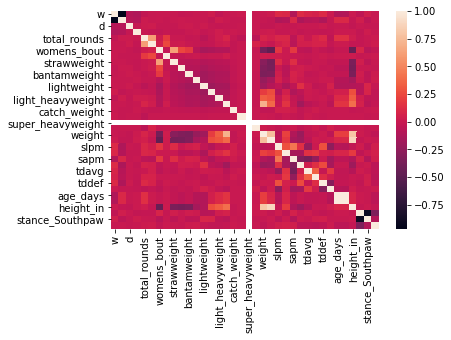

In [82]:
sns.heatmap(train.corr());


In [38]:
# c_cov = ufc_cleaned[ufc_cleaned.fullname.isin(['Colby Covington'])]

In [31]:
# c_cov.head()

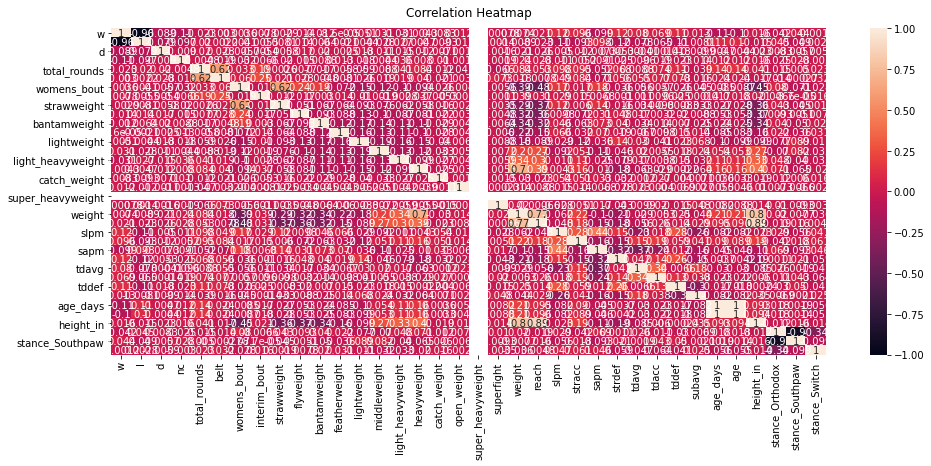

In [83]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [85]:
# Correlation of Independent Variables with the Dependent Variable

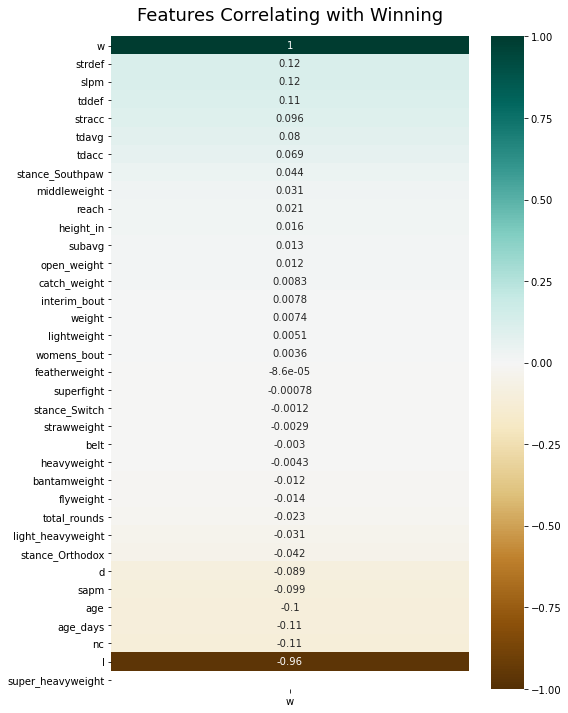

In [87]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['w']].sort_values(by='w', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Winning', fontdict={'fontsize':18}, pad=16);

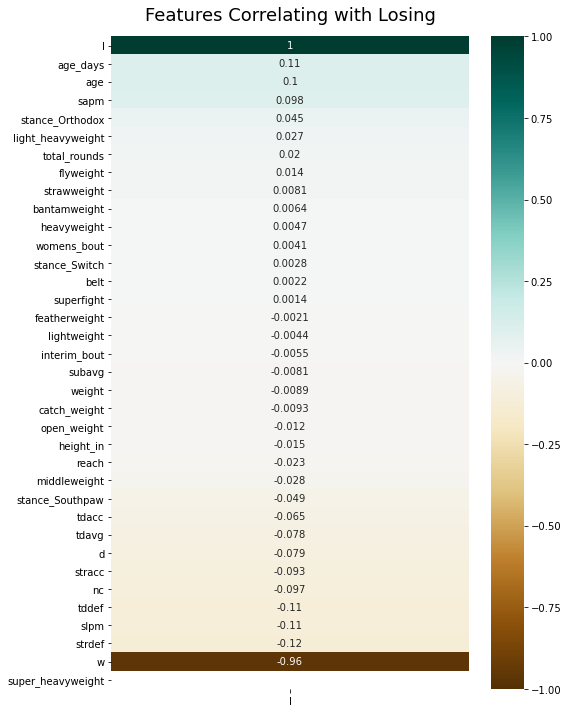

In [88]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['l']].sort_values(by='l', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Losing', fontdict={'fontsize':18}, pad=16);

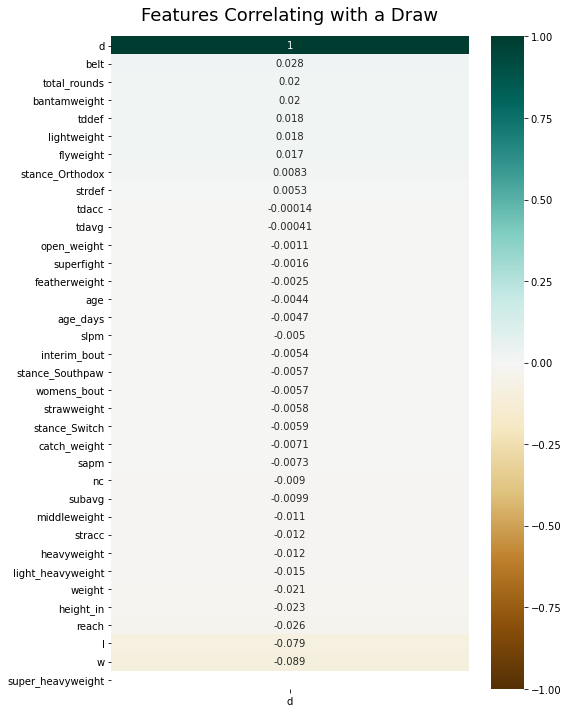

In [89]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['d']].sort_values(by='d', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with a Draw', fontdict={'fontsize':18}, pad=16);

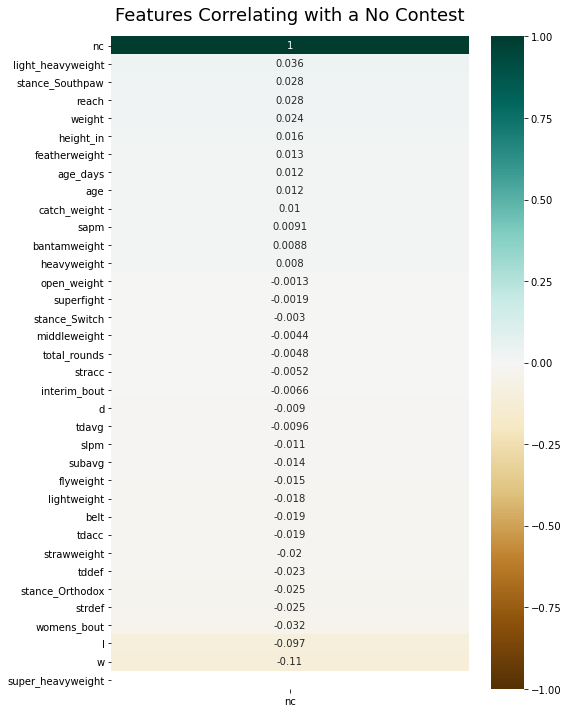

In [91]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['nc']].sort_values(by='nc', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with a No Contest', fontdict={'fontsize':18}, pad=16);

### MVP 

In [109]:
ufc_cleaned.dtypes

event_name            object
fighter               object
opponent              object
w                      int64
l                      int64
d                      int64
nc                     int64
total_rounds           int64
belt                   int64
womens_bout            int64
interim_bout           int64
strawweight            int64
flyweight              int64
bantamweight           int64
featherweight          int64
lightweight            int64
middleweight           int64
light_heavyweight      int64
heavyweight            int64
catch_weight           int64
open_weight            int64
super_heavyweight      int64
superfight             int64
fight_city            object
fight_state           object
fight_country         object
weight               float64
reach                float64
stance                object
slpm                 float64
stracc                 int64
sapm                 float64
strdef                 int64
tdavg                float64
tdacc         

In [120]:
X_train = train.drop(columns=['outcome','event_name', 'fighter', 'opponent', 'fight_city', 'fight_state', 'fight_country', 'stance', 'w', 'l', 'd', 'nc'])
y_train = train.outcome

x_validate = validate.drop(columns=['outcome','event_name', 'fighter', 'opponent', 'fight_city', 'fight_state', 'fight_country', 'stance', 'w', 'l', 'd', 'nc'])
y_validate = validate.outcome

X_test = test.drop(columns=['outcome','event_name', 'fighter', 'opponent', 'fight_city', 'fight_state', 'fight_country', 'stance', 'w', 'l', 'd', 'nc'])
y_test = test.outcome

In [121]:
X_train.head(1)

,total_rounds,belt,womens_bout,interim_bout,strawweight,flyweight,bantamweight,featherweight,lightweight,middleweight,...,tdavg,tdacc,tddef,subavg,age_days,age,height_in,stance_Orthodox,stance_Southpaw,stance_Switch
4307,3,0,0,0,0,0,0,0,1,0,...,1.64,41,71,0.20,12521,34.00,69,1,0,0


#### Baseline

In [122]:
# baseline prediction = most common value
baseline = y_train.mode()
baseline

0    win
dtype: object

In [123]:
match_bsl_prediction = y_train == 'win'

In [124]:
baseline_accuracy = match_bsl_prediction.mean()

In [125]:
baseline_accuracy

0.5215815485996705

In [126]:
# basline accuracy = 52%

#### Decision Tree 

In [127]:
tree1_clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [128]:
tree1_clf = tree1_clf.fit(X_train, y_train)

In [129]:
#visualize the decision tree
import graphviz
from graphviz import Graph

dot_data = export_graphviz(tree1_clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [130]:
# key features: tddef, sapm, age_days, slpm, stracc, 

In [131]:
y_pred = tree1_clf.predict(X_train)
y_pred[0:5]

array(['loss', 'win', 'win', 'win', 'win'], dtype=object)

In [132]:
y_pred_proba = tree1_clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.01315789, 0.60526316, 0.01973684, 0.36184211],
       [0.00732357, 0.37882823, 0.00965379, 0.60419441],
       [0.00732357, 0.37882823, 0.00965379, 0.60419441],
       [0.00385728, 0.48891032, 0.01060752, 0.49662488],
       [0.00732357, 0.37882823, 0.00965379, 0.60419441]])

In [133]:
# accuracy:

In [134]:
print('Accuracy of Decision Tree 1 classifier on training set: {:.2f}'
      .format(tree1_clf.score(X_train, y_train)))

Accuracy of Decision Tree 1 classifier on training set: 0.57


In [138]:
y_train.value_counts()

win           3166
loss          2794
no_contest      66
draw            44
Name: outcome, dtype: int64

In [139]:
# classification report: 

In [140]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        draw       0.00      0.00      0.00        44
        loss       0.57      0.41      0.48      2794
  no_contest       0.00      0.00      0.00        66
         win       0.58      0.74      0.65      3166

    accuracy                           0.57      6070
   macro avg       0.29      0.29      0.28      6070
weighted avg       0.56      0.57      0.56      6070



In [141]:
# make classification report prettier in a df
class_report = classification_report(y_train, y_pred, output_dict=(True))
print("Tree1 depth")
pd.DataFrame(class_report)

Tree1 depth


,draw,loss,no_contest,win,accuracy,macro avg,weighted avg
precision,0.00,0.57,0.00,0.58,0.57,0.29,0.56
recall,0.00,0.41,0.00,0.74,0.57,0.29,0.57
f1-score,0.00,0.48,0.00,0.65,0.57,0.28,0.56
support,44.00,2794.00,66.00,3166.00,0.57,6070.00,6070.00


In [142]:
for i in range(2, 11):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_pred = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_pred, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
           draw    loss  no_contest     win  accuracy  macro avg  weighted avg
precision  0.00    0.55        0.00    0.58      0.57       0.28          0.56
recall     0.00    0.49        0.00    0.66      0.57       0.29          0.57
f1-score   0.00    0.52        0.00    0.62      0.57       0.28          0.56
support   44.00 2794.00       66.00 3166.00      0.57    6070.00       6070.00

Tree with max depth of 3
           draw    loss  no_contest     win  accuracy  macro avg  weighted avg
precision  0.00    0.57        0.00    0.58      0.57       0.29          0.56
recall     0.00    0.41        0.00    0.74      0.57       0.29          0.57
f1-score   0.00    0.48        0.00    0.65      0.57       0.28          0.56
support   44.00 2794.00       66.00 3166.00      0.57    6070.00       6070.00

Tree with max depth of 4
           draw    loss  no_contest     win  accuracy  macro avg  weighted avg
precision  0.00    0.61        0.00    0.59      0.60 

In [143]:
metrics = []  

In [144]:
for i in range(1, 11):
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)
    
    #run the model on train and only TRAIN data 
    tree = tree.fit(X_train, y_train)
    
    #use/test the model to evaluate models performance on train data first...
    in_sample_accuracy = tree.score(X_train, y_train)
    out_sample_accuracy = tree.score(x_validate, y_validate)
    
    output = {'max_depth': i, 'train_accuracy': in_sample_accuracy, 'validate_accuracy': out_sample_accuracy}
    
    metrics.append(output)
    
tree_df = pd.DataFrame(metrics)
tree_df["difference"] = tree_df.train_accuracy - tree_df.validate_accuracy

tree_df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.55,0.54,0.02
1,2,0.57,0.55,0.02
2,3,0.57,0.56,0.01
3,4,0.60,0.57,0.02
4,5,0.61,0.57,0.04
5,6,0.62,0.57,0.05
6,7,0.63,0.56,0.07
7,8,0.65,0.56,0.09
8,9,0.67,0.54,0.14
9,10,0.70,0.54,0.16


In [145]:
# to avoid over-fitting, set a threshhold by looking at the difference

In [146]:
threshold = 0.10  #threshold set for amount of overfit that is tolerated

models = []
metrics = []

for i in range(1, 11):
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)
    #^^^ creates the model
    
    tree = tree.fit(X_train, y_train)   #fit model to train data and only TRAIN data
    
    in_sample_accuracy = tree.score(X_train, y_train)
    out_sample_accuracy = tree.score(x_validate, y_validate)
    #^^^evaluates the models performance on train data first
    
    difference = in_sample_accuracy - out_sample_accuracy
    #^^calculates the difference in accuracy
    
    if difference > threshold:
        break
    #^^adds conditions to check the accuracy vs the threshold
    
    output = {
        'max_depth': i,
        'train_accuracy': in_sample_accuracy,
        'validate_accuracy': out_sample_accuracy,
        'difference': difference}
    #^^^formats the output for each models performance o train and validate
    
    metrics.append(output)
    
    models.append(output)
    
model_df = pd.DataFrame(metrics)
model_df["difference"] = tree_df.train_accuracy - tree_df.validate_accuracy


model_df.head()

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.55,0.54,0.02
1,2,0.57,0.55,0.02
2,3,0.57,0.56,0.01
3,4,0.60,0.57,0.02
4,5,0.61,0.57,0.04


57% accurate

#### Random Forest Model 

In [148]:
# create model
rf1_clf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state=123)  

In [149]:
rf1_clf

RandomForestClassifier(max_depth=10, random_state=123)

In [150]:
rf1_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [151]:
print(rf1_clf.feature_importances_)

[1.43707159e-02 8.64600984e-03 4.70460533e-03 1.05639222e-03
 2.78799746e-03 4.87104415e-03 7.01427384e-03 6.35297301e-03
 7.30269710e-03 7.47937613e-03 6.96698805e-03 4.77603352e-03
 2.07599058e-03 6.59540926e-05 0.00000000e+00 7.23580888e-05
 3.04812396e-02 3.72461566e-02 9.26204293e-02 6.89578142e-02
 8.56157820e-02 6.98538981e-02 6.49453607e-02 5.65816006e-02
 7.40137563e-02 4.37282891e-02 1.49809056e-01 9.16670926e-02
 3.53623008e-02 8.90257799e-03 8.50903219e-03 3.16220393e-03]


In [152]:
y_pred = rf1_clf.predict(X_train)
y_pred

array(['loss', 'loss', 'win', ..., 'win', 'win', 'loss'], dtype=object)

In [153]:
y_pred_proba = rf1_clf.predict_proba(X_train)

In [154]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf1_clf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.76


In [156]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        draw       0.00      0.00      0.00        44
        loss       0.81      0.66      0.73      2794
  no_contest       1.00      0.03      0.06        66
         win       0.73      0.88      0.80      3166

    accuracy                           0.76      6070
   macro avg       0.64      0.39      0.40      6070
weighted avg       0.77      0.76      0.75      6070



In [157]:
class_report = classification_report(y_train, y_pred, output_dict=(True))
print("Tree1 depth")
pd.DataFrame(class_report)

Tree1 depth


,draw,loss,no_contest,win,accuracy,macro avg,weighted avg
precision,0.00,0.81,1.00,0.73,0.76,0.64,0.77
recall,0.00,0.66,0.03,0.88,0.76,0.39,0.76
f1-score,0.00,0.73,0.06,0.80,0.76,0.40,0.75
support,44.00,2794.00,66.00,3166.00,0.76,6070.00,6070.00


In [158]:
# If not-survived is our positive case
TP = 285
FP = 68
FN = 22
TN = 123
ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.8192771084337349
True Positive Rate: 0.9283387622149837
False Positive Rate: 0.35602094240837695
True Negative Rate: 0.643979057591623
False Negative Rate: 0.07166123778501629
Precision: 0.8073654390934845
Recall: 0.9283387622149837
F1 Score: 0.8636363636363636
Support (0): 307
Support (1): 191


In [159]:
max_depth = 16

for i in range(1, max_depth):
    # Create Model
    depth = max_depth - i
    n = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_pred = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_pred, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()


Tree with max depth of 1
           draw    loss  no_contest     win  accuracy  macro avg  weighted avg
precision  1.00    0.95        1.00    0.88      0.91       0.96          0.92
recall     0.30    0.87        0.48    0.97      0.91       0.65          0.91
f1-score   0.46    0.91        0.65    0.92      0.91       0.73          0.91
support   44.00 2794.00       66.00 3166.00      0.91    6070.00       6070.00

Tree with max depth of 2
           draw    loss  no_contest     win  accuracy  macro avg  weighted avg
precision  0.00    0.83        0.00    0.78      0.80       0.40          0.79
recall     0.00    0.74        0.00    0.88      0.80       0.41          0.80
f1-score   0.00    0.78        0.00    0.83      0.80       0.40          0.79
support   44.00 2794.00       66.00 3166.00      0.80    6070.00       6070.00

Tree with max depth of 3
           draw    loss  no_contest     win  accuracy  macro avg  weighted avg
precision  0.00    0.80        0.00    0.75      0.77 

In [160]:
metrics = []
max_depth = 16

for i in range(1, max_depth):
    # Create model
    depth = max_depth - i
    n = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(x_validate, y_validate)

    output = {
        "min_samples_per_leaf": n,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df


,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,1,15,0.91,0.53,0.38
1,2,14,0.80,0.55,0.25
2,3,13,0.77,0.55,0.22
3,4,12,0.75,0.56,0.19
4,5,11,0.73,0.56,0.17
5,6,10,0.71,0.57,0.14
6,7,9,0.69,0.58,0.11
7,8,8,0.67,0.58,0.09
8,9,7,0.65,0.57,0.08
9,10,6,0.64,0.58,0.06


59% accuracy 

In [162]:
# fit knn
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [163]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [164]:
y_pred = knn.predict(X_train)